## 0) Import Libraries and General Script

In [16]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
#import cobra
#from cobra.io import load_model
import pandas as pd
from tqdm import tqdm

# Parameters (Feeding point)
x_feed, y_feed, z_feed = 1.15, 10.24, 0.15     #m

# Monod Kinetics (Modeling of Overflow Metabolism in Batch and Fed-Batch Cultures of Escherichia coli)
# (Lin et.al. 2000)
q_S_max = 1.5     # gS/gX/h
K_S = 0.03         # g/L

# Define seaborn theme
sns.set_theme()
sns.set_context('paper')
# Set the Seaborn color palette
sns.set_palette("colorblind")

# Define scientific formatter in matplotlib
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))
formatter.format = '%.1e'

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import pandas as pd

# dFBA - CFD Lifeline
## 1) Introduction
This jupyter notebook shows how it is possible to combine data coming from CFD simulations with metabolic modeling, specifically dFBA (Dynamic Flux Balance Analysis).

### 1.1) Cell-Lifelines 
First we have to solve the **general micro-balances** for momentum and mass using Computational Fluid Dynamics (Fluent):

$$
\begin{aligned}
&\text{Continuity Equation:}\quad\nabla\cdot\rho U + \frac{\partial \rho}{\partial t} = 0 \\
&\text{Navier-Stokes:}\quad\frac{\partial}{\partial t}\left(\rho U\right)+\nabla\cdot\left(\rho U \otimes U\right) = - \nabla P + \mu \nabla^2+\frac{1}{3}\mu\nabla\left(\nabla\cdot U\right) + \rho g \\
&\text{Mass Balance:}\quad\frac{\partial C_i}{\partial t} + \left(U \cdot \nabla\right)C_i = \mathcal{D}\nabla^2 C_i + r_i
\end{aligned}
$$

**Eulerian Specification of Fluid Flow:**

Field is represented as function of position $x$ and time $t$. **Flow velocity** is represented by the function:
$$
u\left(x,t\right)
$$

**Lagrangian Specification of Fluid Flow:**

Individual **fluid parcels** are followed through time. The fluid parcels (**cells** in our case) are labeled by some (time-independent) vector field $x_0$ (position of the center of mass of parcels at time $t_0$). In the Lagrangian description, the flow is described by a function:
$$
X(x_0,t)
$$
The two specifications are related as follows:
$$
u\left(X\left(x_0,t\right),t\right) = \frac{\partial X}{\partial t}\left(x_0, t\right)
$$
Because both sides describe the velocity of the particle labeled $x_0$ at time $t$.

The **important assumptions** to track **cell lifelines** are:
* Parcels have same density as the broth.
* Parcels have same velocity as fluid flows.
* No boundary layer around the cell.

Load data from the lifelines and plot environment seen by the cell

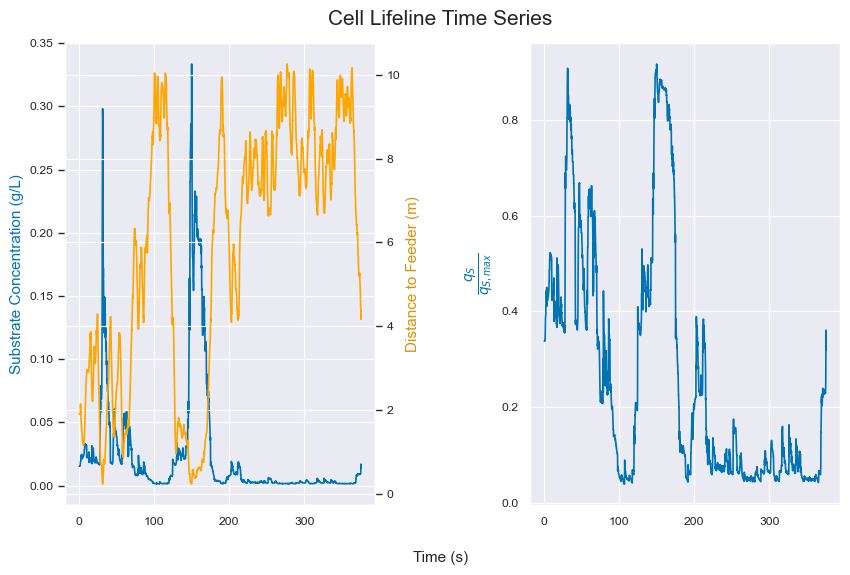

In [2]:
# Load data
delta_t = 0.1      # s
data = np.loadtxt("lifeline_0.out", delimiter=",")
x_array, y_array, z_array, C_S_array = data[:, 0], data[:, 1], data[:, 2], data[:, 3]
time_array = np.arange(0, len(C_S_array)*delta_t, delta_t)

# Compute distance to feeding point
dist_feed_point = np.sqrt((x_array-x_feed)**2 + (y_array-y_feed)**2 + (z_array-z_feed)**2)

# Plot environment seen by the cell and the distance to the feeding point
fig, ax = plt.subplots(1, 2, figsize=(10,6))
sns.lineplot(x=time_array, y=C_S_array, ax=ax[0])
ax[0].set_ylabel("Substrate Concentration (g/L)", fontsize=11,
              color=sns.color_palette()[0])
# Create a second y-axis on the right side 
ax2 = ax[0].twinx()
sns.lineplot(x=time_array, y=dist_feed_point, color='orange', ax=ax2)
ax2.set_ylabel("Distance to Feeder (m)", fontsize=11,
              color=sns.color_palette()[1])

# Plot log10(qS/qSmax) vs time and dist to feed point
q_S= q_S_max*C_S_array/(K_S+C_S_array)
qS_qSmax = q_S/q_S_max
log10_qS_qSmax = np.log10(qS_qSmax)

#plt.title("Cell Lifeline Time Series", fontsize=14)
sns.lineplot(x=time_array, y=qS_qSmax, ax=ax[1])
ax[1].set_ylabel("$\\frac{q_S}{q_{S,max}}$", fontsize=14,
                color=sns.color_palette()[0])
#ax2 = ax[1].twinx()
#sns.lineplot(x=time, y=dist_feed_point, color='orange', ax=ax2)
#ax2.set_ylabel("Distance to Feeder (m)", fontsize=11,
#              color=sns.color_palette()[1])

# Common x-label
fig.supxlabel("Time (s)", fontsize=11)

# Space between subplots
fig.subplots_adjust(wspace=0.5)

# Title
fig.suptitle("Cell Lifeline Time Series", fontsize=15, y=0.935)

plt.show()


### 1.2) dFBA


In [11]:
import cobra
from cobra.io import load_model
import numpy as np

# Monod Kinetics (Modeling of Overflow Metabolism in Batch and Fed-Batch Cultures of Escherichia coli)
# (Lin et.al. 2000)
q_S_max = 1.5     # gS/gX/h
K_S = 0.03         # g/L

def lexicographic_dFBA(C_S: float, model=load_model("textbook")):
    # Re-build model
    model = load_model("textbook")
    
    # Change solver --> When we have cplex cplex, by now glpk
    model.solver = 'glpk'
    
    # Add glucose import as a constraint wih monod
    glucose_max_import = - q_S_max * C_S / (K_S + C_S)
    model.reactions.EX_glc__D_e.lower_bound = glucose_max_import
    
    # 1) Optimize aux-LP to get only feasible solutions
    cobra.util.solver.add_lp_feasibility(model)
    error = model.slim_optimize()
    # Establish feasibility objective as constraint
    cobra.util.fix_objective_as_constraint(model)
    
    # 2) Optimize the Biomass --> Import glucose in Lexicographic form and optimize for qS
    lex_constraints = cobra.util.add_lexicographic_constraints(model, 
                                    ['Biomass_Ecoli_core', 'EX_glc__D_e'], ['max', 'min'])
    
    # 3) Solve model and compute fluxes
    solution = model.optimize()
    fluxes = np.array(model.optimize().fluxes.tolist())
    
    return model, solution, error
    

Solve dFBA with C_S from the lifelines

In [7]:
# Build model
model = load_model("textbook")

# Initialize pd.df solution
fluxes_df = pd.DataFrame(columns=[reaction.id for reaction in model.reactions], index=time_array,)
fluxes_df.index.name = "Time (s)"
errors = []

# Solve dFBA for the cell lifeline
for i in tqdm(range(0,len(time_array))):
    # Call function to solve dFBA
    mode, solution, error = lexicographic_dFBA(C_S=C_S_array[i], model=model)
    
    # Store solution in a pd.df
    fluxes_df.loc[time_array[i]] = solution.fluxes.to_dict()
    
    # Store errors
    errors.append(error)
    
# Include Error as new column in the data frame
fluxes_df['Error'] = errors

# Store pd.df as csv file
fluxes_df.to_csv("dFBA_Textbook_Model_Reaction_Fluxes.csv", sep="\t", header=True, index=True)


100%|██████████| 3756/3756 [29:36<00:00,  2.11it/s]


# Simple Methods to Reduce Cell Lifeline Data
Reduction of observations (Subsampling)

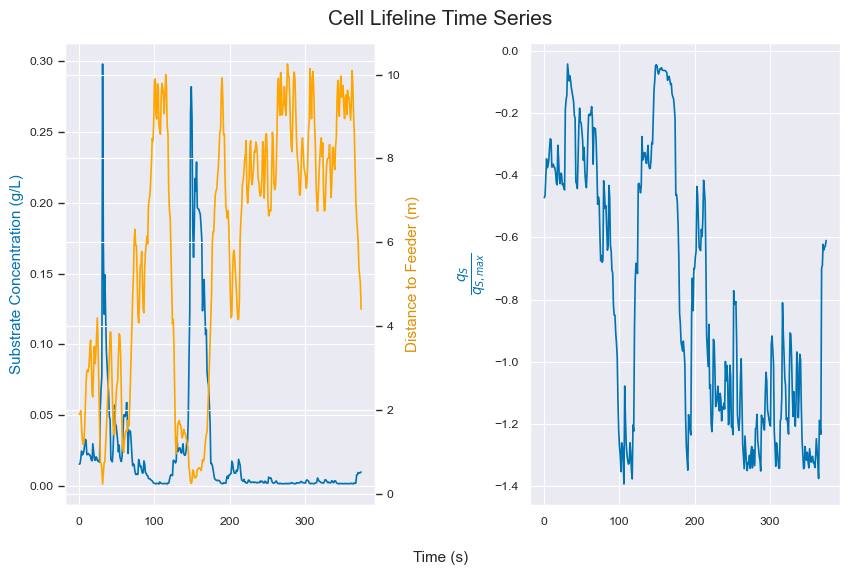

In [7]:
import numpy as np

# Load data
delta_t = 0.1      # s
data = np.loadtxt("lifeline_0.out", delimiter=",")
x_array, y_array, z_array, C_S_array = data[:, 0], data[:, 1], data[:, 2], data[:, 3]
time_array = np.arange(0, len(C_S_array)*delta_t, delta_t)

# Define the desired interval for selecting time points
interval = 10  # Select every 10th time point

# Reduce the dataset by selecting every n-th time point
reduced_time_array = time_array[::interval]
reduced_x_array = x_array[::interval]
reduced_y_array = y_array[::interval]
reduced_z_array = z_array[::interval]
reduced_C_S_array = C_S_array[::interval]

# Compute distance to feeding point for the reduced dataset
reduced_dist_feed_point = np.sqrt((reduced_x_array-x_feed)**2 + (reduced_y_array-y_feed)**2 + (reduced_z_array-z_feed)**2)

# Plot environment seen by the cell and the distance to the feeding point using the reduced dataset
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
sns.lineplot(x=reduced_time_array, y=reduced_C_S_array, ax=ax[0])
ax[0].set_ylabel("Substrate Concentration (g/L)", fontsize=11, color=sns.color_palette()[0])
# Create a second y-axis on the right side 
ax2 = ax[0].twinx()
sns.lineplot(x=reduced_time_array, y=reduced_dist_feed_point, color='orange', ax=ax2)
ax2.set_ylabel("Distance to Feeder (m)", fontsize=11, color=sns.color_palette()[1])

# Plot log10(qS/qSmax) vs time and dist to feed point using the reduced dataset
reduced_q_S = q_S_max * reduced_C_S_array / (K_S + reduced_C_S_array)
reduced_qS_qSmax = reduced_q_S / q_S_max
reduced_log10_qS_qSmax = np.log10(reduced_qS_qSmax)

sns.lineplot(x=reduced_time_array, y=reduced_log10_qS_qSmax, ax=ax[1])
ax[1].set_ylabel("$\\frac{q_S}{q_{S,max}}$", fontsize=14, color=sns.color_palette()[0])

# Common x-label
fig.supxlabel("Time (s)", fontsize=11)

# Space between subplots
fig.subplots_adjust(wspace=0.5)

# Title
fig.suptitle("Cell Lifeline Time Series", fontsize=15, y=0.935)

plt.show()


In [12]:
# Build model
model = load_model("textbook")

# Initialize pd.df solution
fluxes_df = pd.DataFrame(columns=[reaction.id for reaction in model.reactions], index=reduced_time_array)
fluxes_df.index.name = "Time (s)"
errors = []

# Solve dFBA for the reduced cell lifeline
for i in tqdm(range(len(reduced_time_array))):
    # Call function to solve dFBA using reduced C_S value
    mode, solution, error = lexicographic_dFBA(C_S=reduced_C_S_array[i], model=model)
    
    # Store solution in a pd.df
    fluxes_df.loc[reduced_time_array[i]] = solution.fluxes.to_dict()
    
    # Store errors
    errors.append(error)
    
# Include Error as a new column in the data frame
fluxes_df['Error'] = errors

# Store pd.df as a CSV file
fluxes_df.to_csv("dFBA_Textbook_Model_Reaction_Fluxes.csv", sep="\t", header=True, index=True)

100%|██████████| 376/376 [01:49<00:00,  3.45it/s]


Reduction of observations (downsampling and aggregation)

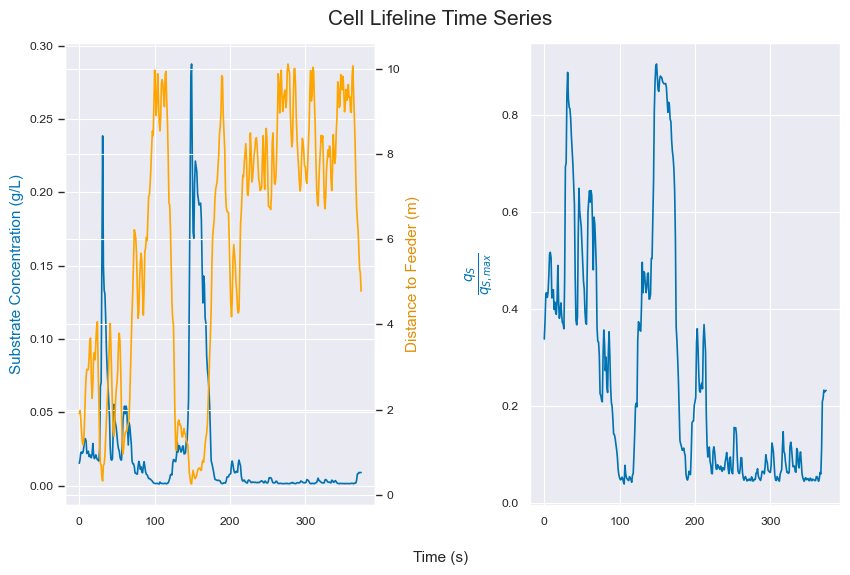

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
delta_t = 0.1      # s
data = np.loadtxt("lifeline_0.out", delimiter=",")
x_array, y_array, z_array, C_S_array = data[:, 0], data[:, 1], data[:, 2], data[:, 3]
time_array = np.arange(0, len(C_S_array)*delta_t, delta_t)

# Downsample and aggregate data
downsample_factor = 10
truncated_length = len(C_S_array) // downsample_factor * downsample_factor  # Truncate to a multiple of downsample_factor
truncated_time_array = time_array[:truncated_length]
truncated_C_S_array = C_S_array[:truncated_length]
aggregated_time_array = truncated_time_array[::downsample_factor]
aggregated_C_S_array = np.mean(truncated_C_S_array.reshape(-1, downsample_factor), axis=1)

# Compute distance to feeding point
dist_feed_point = np.sqrt((x_array-x_feed)**2 + (y_array-y_feed)**2 + (z_array-z_feed)**2)

# Truncate dist_feed_point array to match the length of truncated_C_S_array
truncated_dist_feed_point = dist_feed_point[:truncated_length]

# Downsample and aggregate distance data
aggregated_dist_feed_point = np.mean(truncated_dist_feed_point.reshape(-1, downsample_factor), axis=1)

# Plot environment seen by the cell and the distance to the feeding point
fig, ax = plt.subplots(1, 2, figsize=(10,6))
sns.lineplot(x=aggregated_time_array, y=aggregated_C_S_array, ax=ax[0])
ax[0].set_ylabel("Substrate Concentration (g/L)", fontsize=11, color=sns.color_palette()[0])

# Create a second y-axis on the right side 
ax2 = ax[0].twinx()
sns.lineplot(x=aggregated_time_array, y=aggregated_dist_feed_point, color='orange', ax=ax2)
ax2.set_ylabel("Distance to Feeder (m)", fontsize=11, color=sns.color_palette()[1])

# Compute qS/qSmax
q_S = q_S_max * aggregated_C_S_array / (K_S + aggregated_C_S_array)
qS_qSmax = q_S / q_S_max
log10_qS_qSmax = np.log10(qS_qSmax)

sns.lineplot(x=aggregated_time_array, y=qS_qSmax, ax=ax[1])
ax[1].set_ylabel("$\\frac{q_S}{q_{S,max}}$", fontsize=14, color=sns.color_palette()[0])

# Common x-label
fig.supxlabel("Time (s)", fontsize=11)

# Space between subplots
fig.subplots_adjust(wspace=0.5)

# Title
fig.suptitle("Cell Lifeline Time Series", fontsize=15, y=0.935)

plt.show()


In [14]:
# Build model
model = load_model("textbook")

# Initialize pd.df solution
fluxes_df = pd.DataFrame(columns=[reaction.id for reaction in model.reactions], index=aggregated_time_array)
fluxes_df.index.name = "Time (s)"
errors = []

# Solve dFBA for the cell lifeline
for i in tqdm(range(0, len(aggregated_time_array))):
    # Call function to solve dFBA
    mode, solution, error = lexicographic_dFBA(C_S=aggregated_C_S_array[i], model=model)
    
    # Store solution in a pd.df
    fluxes_df.loc[aggregated_time_array[i]] = solution.fluxes.to_dict()
    
    # Store errors
    errors.append(error)

# Include Error as a new column in the data frame
fluxes_df['Error'] = errors

# Store pd.df as a CSV file
fluxes_df.to_csv("dFBA_Textbook_Model_Reaction_Fluxes_agg.csv", sep="\t", header=True, index=True)

100%|██████████| 375/375 [02:10<00:00,  2.86it/s]


Data Visualization

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the CSV file
fluxes_df = pd.read_csv("dFBA_Textbook_Model_Reaction_Fluxes.csv", sep="\t", index_col=0)

# Filtering reactions
# Select subset of equidistant time points
# equidistant_time_points = [0, 10, 20, 30, 40]  # Example equidistant time points to select
# filtered_fluxes_df = fluxes_df.iloc[equidistant_time_points]

# Remove reactions with constant values over time
non_constant_fluxes_df = fluxes_df.loc[:, (fluxes_df != fluxes_df.iloc[0]).any()]
removed_constant_reactions = len(fluxes_df.columns) - len(non_constant_fluxes_df.columns)
print("Number of reactions removed due to constant values over time:", removed_constant_reactions)

# Eliminate transport and exchange reactions
# non_transport_exchange_fluxes_df = non_constant_fluxes_df[~non_constant_fluxes_df.index.str.contains("transport|exchange", case=False)]
# removed_transport_exchange_reactions = len(non_constant_fluxes_df.index) - len(non_transport_exchange_fluxes_df.index)
# print("Number of transport and exchange reactions removed:", removed_transport_exchange_reactions)

# Remove redundant reactions, keep one representative for coupled reactions
unique_reactions_fluxes_df = non_constant_fluxes_df.loc[:, ~non_constant_fluxes_df.columns.duplicated()]
removed_redundant_reactions = len(non_constant_fluxes_df.columns) - len(unique_reactions_fluxes_df.columns)
print("Number of redundant reactions removed:", removed_redundant_reactions)

# Calculate the correlation matrix
# corr_matrix = unique_reactions_fluxes_df.transpose().corr()

# Create a heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, fmt=".2f", square=True)
# plt.title("Correlation Matrix of Reaction Fluxes")
# plt.xticks(rotation=90)
# plt.yticks(rotation=0)
# plt.show()


Number of reactions removed due to constant values over time: 49
Number of redundant reactions removed: 0


# Establishing Autoencoder

Reshaping so we reduce matrix size accordingly (3756,96,1) goes to (3756,10)

In [19]:
import optuna
from keras.layers import Input, Dense, Reshape
from keras.models import Model
from sklearn.model_selection import train_test_split

In [20]:
fluxes_df

,ACALD,ACALDt,ACKr,ACONTa,ACONTb,ACt2r,ADK1,AKGDH,AKGt2r,ALCD2x,...,SUCCt2_2,SUCCt3,SUCDi,SUCOAS,TALA,THD2,TKT1,TKT2,TPI,Error
Time (s),,,,,,,,,,,,,,,,,,,,,
0.0,0.0,0.0,0.0,0.977225,0.977225,0.0,0.0,0.974547,0.0,0.0,...,0.0,0.0,0.974547,-0.974547,-0.000444,0.0,-0.000444,-0.001340,0.503671,-1.662941e-15
0.1,0.0,0.0,0.0,0.977225,0.977225,0.0,0.0,0.974547,0.0,0.0,...,0.0,0.0,0.974547,-0.974547,-0.000444,0.0,-0.000444,-0.001340,0.503671,-1.662941e-15
0.2,0.0,0.0,0.0,0.977225,0.977225,0.0,0.0,0.974547,0.0,0.0,...,0.0,0.0,0.974547,-0.974547,-0.000444,0.0,-0.000444,-0.001340,0.503671,-1.662941e-15
0.3,0.0,0.0,0.0,0.977225,0.977225,0.0,0.0,0.974547,0.0,0.0,...,0.0,0.0,0.974547,-0.974547,-0.000444,0.0,-0.000444,-0.001340,0.503671,-1.662941e-15
0.4,0.0,0.0,0.0,0.977225,0.977225,0.0,0.0,0.974547,0.0,0.0,...,0.0,0.0,0.974547,-0.974547,-0.000444,0.0,-0.000444,-0.001340,0.503671,-1.662941e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375.1,0.0,0.0,0.0,0.950241,0.950241,0.0,0.0,0.950241,0.0,0.0,...,0.0,0.0,0.950241,-0.950241,0.040208,0.0,-0.020104,0.040208,0.485173,6.031235e-02
375.2,0.0,0.0,0.0,0.981516,0.981516,0.0,0.0,0.978212,0.0,0.0,...,0.0,0.0,0.978212,-0.978212,-0.000548,0.0,-0.000548,-0.001654,0.509334,-2.675166e-15
375.3,0.0,0.0,0.0,1.001194,1.001194,0.0,0.0,0.995020,0.0,0.0,...,0.0,0.0,0.995020,-0.995020,-0.001024,0.0,-0.001024,-0.003090,0.535305,-7.230179e-16


In [21]:
unique_reactions_fluxes_df

,ACONTa,ACONTb,AKGDH,ATPS4r,Biomass_Ecoli_core,CO2t,CS,CYTBD,ENO,EX_co2_e,...,PYK,RPE,RPI,SUCDi,SUCOAS,TALA,TKT1,TKT2,TPI,Error
Time (s),,,,,,,,,,,,,,,,,,,,,
0.0,0.977225,0.977225,0.974547,6.575149,2.482764e-03,-2.931188,0.977225,5.856635,1.001967,2.931188,...,0.487423,-0.001785,-0.001785,0.974547,-0.974547,-0.000444,-0.000444,-0.001340,0.503671,-1.662941e-15
0.1,0.977225,0.977225,0.974547,6.575149,2.482764e-03,-2.931188,0.977225,5.856635,1.001967,2.931188,...,0.487423,-0.001785,-0.001785,0.974547,-0.974547,-0.000444,-0.000444,-0.001340,0.503671,-1.662941e-15
0.2,0.977225,0.977225,0.974547,6.575149,2.482764e-03,-2.931188,0.977225,5.856635,1.001967,2.931188,...,0.487423,-0.001785,-0.001785,0.974547,-0.974547,-0.000444,-0.000444,-0.001340,0.503671,-1.662941e-15
0.3,0.977225,0.977225,0.974547,6.575149,2.482764e-03,-2.931188,0.977225,5.856635,1.001967,2.931188,...,0.487423,-0.001785,-0.001785,0.974547,-0.974547,-0.000444,-0.000444,-0.001340,0.503671,-1.662941e-15
0.4,0.977225,0.977225,0.974547,6.575149,2.482764e-03,-2.931188,0.977225,5.856635,1.001967,2.931188,...,0.487423,-0.001785,-0.001785,0.974547,-0.974547,-0.000444,-0.000444,-0.001340,0.503671,-1.662941e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375.1,0.950241,0.950241,0.950241,6.429205,1.506328e-17,-2.850723,0.950241,5.701447,0.950241,2.850723,...,0.545485,0.020104,0.020104,0.950241,-0.950241,0.040208,-0.020104,0.040208,0.485173,6.031235e-02
375.2,0.981516,0.981516,0.978212,6.599177,3.062713e-03,-2.943946,0.981516,5.880810,1.012037,2.943946,...,0.489290,-0.002201,-0.002201,0.978212,-0.978212,-0.000548,-0.000548,-0.001654,0.509334,-2.675166e-15
375.3,1.001194,1.001194,0.995020,6.709377,5.722566e-03,-3.002458,1.001194,5.991683,1.058221,3.002458,...,0.497855,-0.004113,-0.004113,0.995020,-0.995020,-0.001024,-0.001024,-0.003090,0.535305,-7.230179e-16


In [23]:
data.shape

(3756, 47)

In [8]:
import numpy as np
import pandas as pd
import keras
from keras.layers import Input, LSTM, RepeatVector, Dense
from keras.models import Model
from sklearn.model_selection import TimeSeriesSplit
from keras.utils import Sequence
from sklearn.preprocessing import StandardScaler

# Convert the DataFrame to a numpy array
data = unique_reactions_fluxes_df.to_numpy()

# Normalize the data feature-wise
scaler = StandardScaler()
normalized_data_2d = scaler.fit_transform(data)
normalized_data = normalized_data_2d.reshape(normalized_data_2d.shape[0], normalized_data_2d.shape[1], 1)

original_data = normalized_data

# Define the input layer
inp = Input(shape=(original_data.shape[1], original_data.shape[2]))

# Encoder layers
encoder = LSTM(100, activation='tanh', return_sequences=False, kernel_initializer='glorot_uniform')(inp)
latent = Dense(40, activation='tanh')(encoder)

# Decoder layers
repeated_latent = RepeatVector(original_data.shape[1])(latent)
decoder = LSTM(100, activation='tanh', return_sequences=True)(repeated_latent)
output = LSTM(original_data.shape[2], activation='linear', return_sequences=True)(decoder)

# Create the autoencoder model
autoencoder = Model(inputs=inp, outputs=output)
autoencoder.compile(optimizer='adam', loss='mse')

# Capture the initial weights
initial_weights = autoencoder.get_weights()

In [9]:
normalized_data.shape

(3756, 47, 1)

In [15]:
original_data.shape

(3756, 47, 1)

In [12]:
original_data.shape[1]

47

In [13]:
original_data.shape[2]

1

In [14]:
# DataGenerator class
class DataGenerator(Sequence):
    def __init__(self, data, batch_size=32, shuffle=False):
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.data))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_data = self.data[batch_indices]
        return batch_data, batch_data

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

for train_index, val_index in tscv.split(original_data):
    # Split data
    train, val = original_data[train_index], original_data[val_index]
    
    # Create data generators for this fold
    train_gen = DataGenerator(train, batch_size=32, shuffle=True)
    val_gen = DataGenerator(val, batch_size=32)
    
    # Uncomment the next line if you want to reset weights for each fold
    # autoencoder.set_weights(initial_weights)

    # Fit the autoencoder for this fold using the generators
    history = autoencoder.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=[reduce_lr, early_stop])


Epoch 1/50
20/20 [==============================] - 8s 195ms/step - loss: 1.3130 - val_loss: 0.5587 - lr: 0.0010
Epoch 2/50
20/20 [==============================] - 3s 131ms/step - loss: 1.2166 - val_loss: 0.5314 - lr: 0.0010
Epoch 3/50
20/20 [==============================] - 3s 127ms/step - loss: 1.1606 - val_loss: 0.5059 - lr: 0.0010
Epoch 4/50
20/20 [==============================] - 3s 136ms/step - loss: 1.1219 - val_loss: 0.4963 - lr: 0.0010
Epoch 5/50
20/20 [==============================] - 3s 132ms/step - loss: 1.0965 - val_loss: 0.4759 - lr: 0.0010
Epoch 6/50
20/20 [==============================] - 3s 140ms/step - loss: 1.0774 - val_loss: 0.4662 - lr: 0.0010
Epoch 7/50
20/20 [==============================] - 3s 135ms/step - loss: 1.0768 - val_loss: 0.4628 - lr: 0.0010
Epoch 8/50
20/20 [==============================] - 3s 136ms/step - loss: 1.0745 - val_loss: 0.4356 - lr: 0.0010
Epoch 9/50
20/20 [==============================] - 3s 145ms/step - loss: 1.0394 - val_loss: 0.4

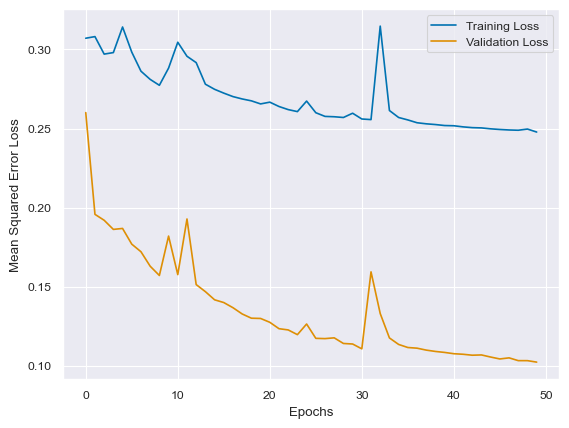

In [9]:
# Optional: Plot the training loss and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error Loss')
plt.legend()
plt.show()

In [10]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
train_data, test_data = train_test_split(original_data, test_size=0.2, random_state=42)

encoder_model = Model(inputs=inp, outputs=latent)
latent_data = encoder_model.predict(test_data) # Predict the latent data for test set
reconstructed_data = autoencoder.predict(test_data) # Predict the reconstructed data for test set


24/24 [==============================] - 2s 33ms/step


Data Visualization

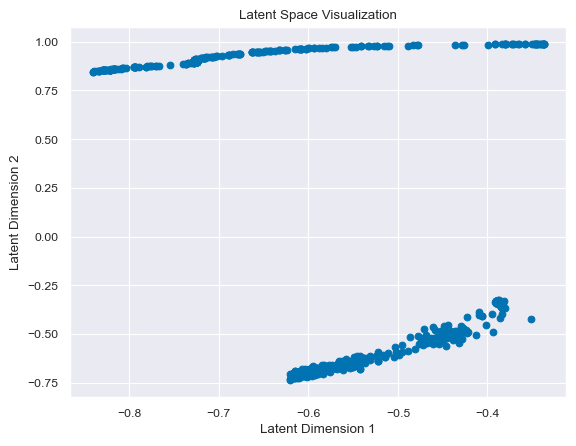

118/118 [==============================] - 4s 37ms/step
Loss Difference: 0.23135263994263291


In [11]:
import matplotlib.pyplot as plt

# Visualize the latent space
plt.scatter(latent_data[:, 0], latent_data[:, 1])
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Visualization')
plt.show()

# Compute the loss difference
reconstructed_data = autoencoder.predict(original_data )
loss_difference = np.mean(np.abs(reconstructed_data - original_data ))

print("Loss Difference:", loss_difference)


In [12]:
# Get the shapes of the original data and latent space
original_shape = original_data .shape
latent_shape = latent_data.shape

# Compare the sizes of the original data and latent space
print("Original Data Shape:", original_shape)
print("Latent Space Shape:", latent_shape)

# Compute the reduction percentage
original_data_points = original_shape[0] * original_shape[1]
latent_data_points = latent_shape[0] * latent_shape[1]
reduction_percentage = 100 - (latent_data_points / original_data_points) * 100
#reduction_percentage = (latent_shape[1] / original_shape[1]) * 100
print("Reduction Percentage:", reduction_percentage)


Original Data Shape: (3756, 47, 1)
Latent Space Shape: (752, 40)
Reduction Percentage: 82.96059637912673


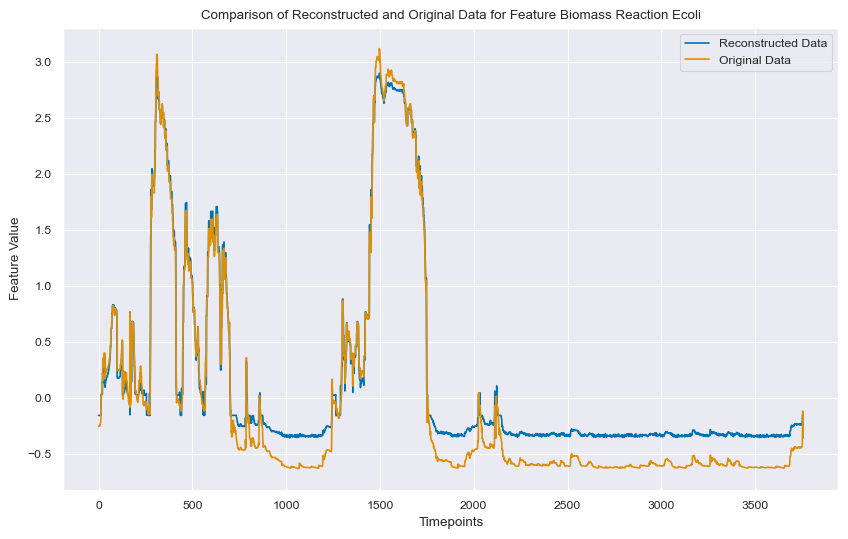

In [13]:
# Select a random feature for comparison
feature_index = np.random.randint(low=0, high=original_data.shape[1])
feature_index = 6

# Extract this feature across all samples from the original data
original_feature_values = original_data[:, feature_index]

# Extract the same feature from the reconstructed data
reconstructed_feature_values = reconstructed_data[:, feature_index, 0]  # Accessing the 0th index because the reconstructed data is 3-dimensional

# Plot the reconstructed values for this feature
plt.figure(figsize=(10, 6))
plt.plot(reconstructed_feature_values, label='Reconstructed Data')

# Plot the original values for this feature
plt.plot(original_feature_values, label='Original Data')

plt.xlabel('Timepoints')
plt.ylabel('Feature Value')
plt.title(f'Comparison of Reconstructed and Original Data for Feature Biomass Reaction Ecoli')
plt.legend()
plt.show()


c:\Users\elysi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


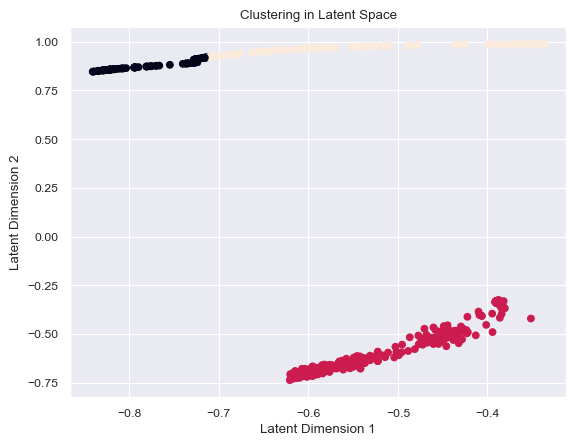

In [14]:
from sklearn.cluster import KMeans

# Perform clustering on the latent space
kmeans = KMeans(n_clusters=3)  # Specify the desired number of clusters
clusters = kmeans.fit_predict(latent_data)

# Visualize the clusters
plt.scatter(latent_data[:, 0], latent_data[:, 1], c=clusters)
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Clustering in Latent Space')
plt.show()


In [15]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 47, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 40)                4040      
                                                                 
 repeat_vector (RepeatVecto  (None, 47, 40)            0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 47, 100)           56400     
                                                                 
 lstm_2 (LSTM)               (None, 47, 1)             408       
                                                             

In [16]:
# Get the weights from encoder LSTM to the latent space
encoder_to_latent_weights = autoencoder.layers[1].get_weights()[0]

# Get the weights from latent space to the decoder LSTM
latent_to_decoder_weights = autoencoder.layers[2].get_weights()[0]

# Compute the feature importance
encoder_importance = np.mean(np.abs(encoder_to_latent_weights), axis=0)
decoder_importance = np.mean(np.abs(latent_to_decoder_weights), axis=1)

# Sort the features based on importance
sorted_indices = np.argsort(decoder_importance)[::-1]
sorted_importance = decoder_importance[sorted_indices]

# Print the sorted features and their importance
for i, index in enumerate(sorted_indices):
    print(f"Feature {index+1}: Importance = {sorted_importance[i]}")


Feature 8: Importance = 0.1421441286802292
Feature 34: Importance = 0.13628587126731873
Feature 57: Importance = 0.13243940472602844
Feature 77: Importance = 0.12998607754707336
Feature 52: Importance = 0.12763582170009613
Feature 50: Importance = 0.12539805471897125
Feature 39: Importance = 0.12523861229419708
Feature 97: Importance = 0.12250293791294098
Feature 75: Importance = 0.12229029834270477
Feature 65: Importance = 0.1216290220618248
Feature 46: Importance = 0.12062851339578629
Feature 58: Importance = 0.11976931244134903
Feature 25: Importance = 0.11954901367425919
Feature 79: Importance = 0.1190839558839798
Feature 73: Importance = 0.11778609454631805
Feature 27: Importance = 0.11650937795639038
Feature 74: Importance = 0.11579088121652603
Feature 68: Importance = 0.11565744876861572
Feature 3: Importance = 0.11553265899419785
Feature 92: Importance = 0.11530692875385284
Feature 84: Importance = 0.11518321931362152
Feature 31: Importance = 0.11509350687265396
Feature 70: Imp

Save data to run in R for clustering + random forest classification

In [17]:
import pandas as pd

# Convert the latent data to a DataFrame
latent_df = pd.DataFrame(latent_data)

# Save to a CSV file
latent_df.to_csv("latent_data_oct22.csv", index=False)


# Hyperparameter Tuning 
Needs to be worked on (did not update from previous weeks)

In [9]:
import optuna
from keras.layers import Input, Dense, Reshape
from keras.models import Model
from sklearn.model_selection import train_test_split

In [10]:
import numpy as np
import optuna
from sklearn.model_selection import TimeSeriesSplit
from keras.layers import Input, LSTM, RepeatVector, Dense
from keras.models import Model
from keras.utils import Sequence
from sklearn.preprocessing import StandardScaler
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Convert the DataFrame to a numpy array
data = fluxes_df.to_numpy()

# Normalize the data using StandardScaler
scaler = StandardScaler()
normalized_data_2d = scaler.fit_transform(data)
normalized_data = normalized_data_2d.reshape(normalized_data_2d.shape[0], normalized_data_2d.shape[1], 1)

# Store the original data
original_data = normalized_data

class DataGenerator(Sequence):
    def __init__(self, data, batch_size=32, shuffle=False):
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.data))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_data = self.data[batch_indices]
        return batch_data, batch_data

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

def objective(trial):
    lstm_units = trial.suggest_int('lstm_units', 5, 100)
    latent_units = trial.suggest_int('latent_units', 5, 100)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    activation_fn = trial.suggest_categorical('activation_fn', ['tanh'])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

    inp = Input(shape=(original_data.shape[1], original_data.shape[2]))
    encoder = LSTM(lstm_units, activation=activation_fn, return_sequences=False)(inp)
    latent = Dense(latent_units, activation=activation_fn)(encoder)
    repeated_latent = RepeatVector(original_data.shape[1])(latent)
    decoder = LSTM(lstm_units, activation=activation_fn, return_sequences=True)(repeated_latent)
    output = LSTM(original_data.shape[2], activation='linear', return_sequences=True)(decoder)

    autoencoder = Model(inputs=inp, outputs=output)
    optimizer = Adam(learning_rate=learning_rate)
    autoencoder.compile(optimizer=optimizer, loss='mse')

    tscv = TimeSeriesSplit(n_splits=4)
    rmse = []

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    for train_index, test_index in tscv.split(normalized_data):
        train_data, val_data = normalized_data[train_index], normalized_data[test_index]
        train_gen = DataGenerator(train_data, batch_size=batch_size, shuffle=True)
        val_gen = DataGenerator(val_data, batch_size=batch_size)

        autoencoder.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=[reduce_lr, early_stop])

        reconstruction_loss = np.mean(np.square(val_data - autoencoder.predict(val_gen)))
        rmse.append(reconstruction_loss)

    return np.mean(rmse)


In [23]:
study = optuna.create_study(direction='minimize')  # Create a new study with minimization as the goal
study.optimize(objective, n_trials=3)  # Invoke optimization of the objective function

[I 2023-10-22 21:39:14,256] A new study created in memory with name: no-name-a90d3403-26e4-4a8e-a02b-23c354b1c004


Epoch 1/50
12/12 [==============================] - 8s 291ms/step - loss: 0.6099 - val_loss: 0.4232 - lr: 0.0031
Epoch 2/50
12/12 [==============================] - 3s 219ms/step - loss: 0.5944 - val_loss: 0.4526 - lr: 0.0031
Epoch 3/50
12/12 [==============================] - 3s 252ms/step - loss: 0.5874 - val_loss: 0.4750 - lr: 0.0031
Epoch 4/50
12/12 [==============================] - 3s 249ms/step - loss: 0.5799 - val_loss: 0.5070 - lr: 0.0031
Epoch 5/50
12/12 [==============================] - 3s 223ms/step - loss: 0.5633 - val_loss: 0.5044 - lr: 0.0031
Epoch 6/50
12/12 [==============================] - 3s 235ms/step - loss: 0.5592 - val_loss: 0.4569 - lr: 0.0031
Epoch 7/50
12/12 [==============================] - 3s 218ms/step - loss: 0.5498 - val_loss: 0.4738 - lr: 0.0016
Epoch 8/50
12/12 [==============================] - 3s 217ms/step - loss: 0.5444 - val_loss: 0.4622 - lr: 0.0016
Epoch 9/50
12/12 [==============================] - 3s 217ms/step - loss: 0.5395 - val_loss: 0.4

[I 2023-10-22 21:55:43,719] Trial 0 finished with value: 0.30522067475366244 and parameters: {'lstm_units': 52, 'latent_units': 31, 'batch_size': 64, 'activation_fn': 'tanh', 'learning_rate': 0.0031264640667966687}. Best is trial 0 with value: 0.30522067475366244.


Epoch 1/50
47/47 [==============================] - 10s 136ms/step - loss: 0.6243 - val_loss: 0.4025 - lr: 5.0223e-05
Epoch 2/50
47/47 [==============================] - 6s 121ms/step - loss: 0.6143 - val_loss: 7.3315 - lr: 5.0223e-05
Epoch 3/50
47/47 [==============================] - 5s 116ms/step - loss: 0.6115 - val_loss: 8.1732 - lr: 5.0223e-05
Epoch 4/50
47/47 [==============================] - 6s 117ms/step - loss: 0.6098 - val_loss: 3.9979 - lr: 5.0223e-05
Epoch 5/50
47/47 [==============================] - 5s 115ms/step - loss: 0.6079 - val_loss: 0.5459 - lr: 5.0223e-05
Epoch 6/50
47/47 [==============================] - 5s 113ms/step - loss: 0.6061 - val_loss: 0.4661 - lr: 5.0223e-05
Epoch 7/50
47/47 [==============================] - 6s 118ms/step - loss: 0.6048 - val_loss: 0.4756 - lr: 5.0223e-05
Epoch 8/50
47/47 [==============================] - 5s 116ms/step - loss: 0.6035 - val_loss: 0.9195 - lr: 5.0223e-05
Epoch 9/50
47/47 [==============================] - 5s 116ms/st

[I 2023-10-22 22:23:30,166] Trial 1 finished with value: 0.404697026950167 and parameters: {'lstm_units': 41, 'latent_units': 69, 'batch_size': 16, 'activation_fn': 'tanh', 'learning_rate': 5.0222561419427374e-05}. Best is trial 0 with value: 0.30522067475366244.


Epoch 1/50
12/12 [==============================] - 7s 242ms/step - loss: 0.6265 - val_loss: 0.3914 - lr: 1.7464e-04
Epoch 2/50
12/12 [==============================] - 2s 160ms/step - loss: 0.6224 - val_loss: 0.3935 - lr: 1.7464e-04
Epoch 3/50
12/12 [==============================] - 2s 157ms/step - loss: 0.6184 - val_loss: 0.3983 - lr: 1.7464e-04
Epoch 4/50
12/12 [==============================] - 2s 171ms/step - loss: 0.6137 - val_loss: 0.4108 - lr: 1.7464e-04
Epoch 5/50
12/12 [==============================] - 2s 185ms/step - loss: 0.6081 - val_loss: 0.4390 - lr: 1.7464e-04
Epoch 6/50
12/12 [==============================] - 2s 177ms/step - loss: 0.6054 - val_loss: 0.4553 - lr: 1.7464e-04
Epoch 7/50
12/12 [==============================] - 2s 142ms/step - loss: 0.6040 - val_loss: 0.4471 - lr: 1.0000e-04
Epoch 8/50
12/12 [==============================] - 2s 167ms/step - loss: 0.6027 - val_loss: 0.4463 - lr: 1.0000e-04
Epoch 9/50
12/12 [==============================] - 2s 172ms/ste

[I 2023-10-22 22:33:07,669] Trial 2 finished with value: 0.39507040613682254 and parameters: {'lstm_units': 44, 'latent_units': 37, 'batch_size': 64, 'activation_fn': 'tanh', 'learning_rate': 0.00017464264555842}. Best is trial 0 with value: 0.30522067475366244.


In [27]:
# After optimizing with Optuna
best_params = study.best_params
print(best_params)

{'lstm_units': 52, 'latent_units': 31, 'batch_size': 64, 'activation_fn': 'tanh', 'learning_rate': 0.0031264640667966687}


In [28]:
import numpy as np
from keras.layers import Input, LSTM, RepeatVector, Dense
from keras.models import Model
from keras.optimizers import Adam
import json

train_data = original_data   

# Use the best parameters from Optuna optimization in your model
lstm_units = best_params['lstm_units']
latent_units = best_params['latent_units']
batch_size = best_params['batch_size']
activation_fn = best_params['activation_fn']
learning_rate = best_params['learning_rate']

# Define the autoencoder model with best hyperparameters
inp = Input(shape=(train_data.shape[1], train_data.shape[2]))

# Encoder layers
encoder = LSTM(lstm_units, activation=activation_fn, return_sequences=False)(inp)
latent = Dense(latent_units, activation=activation_fn)(encoder)

# Decoder layers
repeated_latent = RepeatVector(train_data.shape[1])(latent)
decoder = LSTM(lstm_units, activation=activation_fn, return_sequences=True)(repeated_latent)
output = LSTM(train_data.shape[2], activation='linear', return_sequences=True)(decoder)

# Create and compile the autoencoder model
autoencoder = Model(inputs=inp, outputs=output)
optimizer = Adam(learning_rate=learning_rate)
autoencoder.compile(optimizer=optimizer, loss='mse')

# Train the autoencoder using the generator
train_gen = DataGenerator(train_data, batch_size=batch_size)
autoencoder.fit(train_gen, epochs=20)


Epoch 1/20
59/59 [==============================] - 27s 229ms/step - loss: 0.4877
Epoch 2/20
59/59 [==============================] - 16s 275ms/step - loss: 0.4730
Epoch 3/20
59/59 [==============================] - 15s 249ms/step - loss: 0.4884
Epoch 4/20
59/59 [==============================] - 18s 297ms/step - loss: 0.4620
Epoch 5/20
59/59 [==============================] - 17s 278ms/step - loss: 0.4837
Epoch 6/20
59/59 [==============================] - 11s 186ms/step - loss: 0.4797
Epoch 7/20
59/59 [==============================] - 16s 263ms/step - loss: 0.4857
Epoch 8/20
59/59 [==============================] - 16s 265ms/step - loss: 0.4838
Epoch 9/20
59/59 [==============================] - 14s 236ms/step - loss: 0.4774
Epoch 10/20
59/59 [==============================] - 11s 195ms/step - loss: 0.4710
Epoch 11/20
59/59 [==============================] - 16s 272ms/step - loss: 0.4784
Epoch 12/20
59/59 [==============================] - 16s 262ms/step - loss: 0.4851
Epoch 13/20
5

118/118 [==============================] - 9s 75ms/step


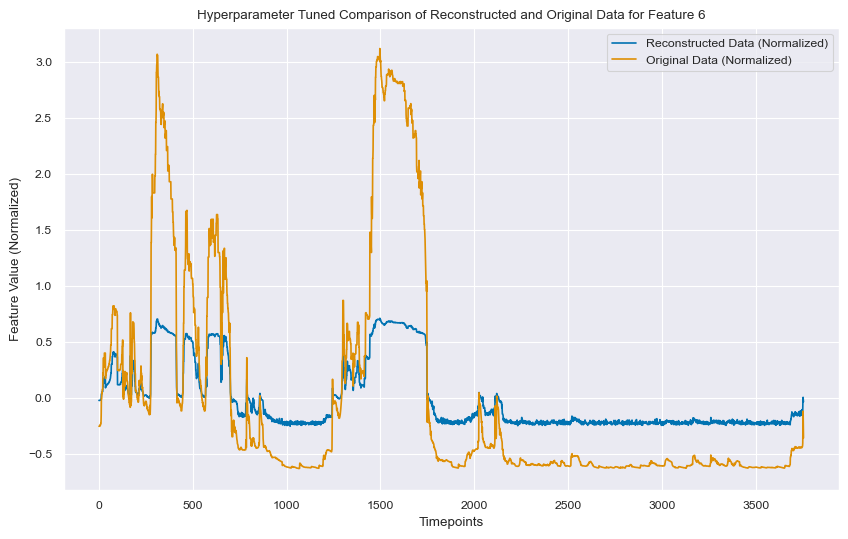

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Use the trained autoencoder to reconstruct the data
reconstructed_data = autoencoder.predict(train_data)

# Extract a feature from the original data for comparison
feature_index = 6
original_feature_values_normalized = train_data[:, feature_index]

# Extract the same feature from the reconstructed data
reconstructed_feature_values = reconstructed_data[:, feature_index, 0]

# Plot the reconstructed values for this feature
plt.figure(figsize=(10, 6))
plt.plot(reconstructed_feature_values, label='Reconstructed Data (Normalized)')

# Plot the original values for this feature
plt.plot(original_feature_values, label='Original Data (Normalized)')

plt.xlabel('Timepoints')
plt.ylabel('Feature Value (Normalized)')
plt.title(f'Hyperparameter Tuned Comparison of Reconstructed and Original Data for Feature {feature_index}')
plt.legend()
plt.show()


In [35]:
best_params = study.best_params
best_loss = study.best_value
print("Best Hyperparameters:", best_params)
print("Best Loss:", best_loss)


Best Hyperparameters: {'lstm_units': 52, 'latent_units': 31, 'batch_size': 64, 'activation_fn': 'tanh', 'learning_rate': 0.0031264640667966687}
Best Loss: 0.30522067475366244


In [ ]:
# Get the latent space representations
latent_data = encoder_model.predict(reshaped_data)

# Perform regression analysis
reg_model = LinearRegression()
reg_model.fit(latent_data, target_variable)
reg_predictions = reg_model.predict(latent_data)

# Perform k-nearest neighbors analysis
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(latent_data, target_variable)
knn_predictions = knn_model.predict(latent_data)

# Visualize the results
plt.scatter(latent_data, target_variable, label='Actual')
plt.plot(latent_data, reg_predictions, label='Regression Predictions')
plt.plot(latent_data, knn_predictions, label='k-NN Predictions')
plt.xlabel('Latent Space')
plt.ylabel('Target Variable')
plt.title('Regression and k-NN Predictions in Latent Space')
plt.legend()
plt.show()

## Regularized Autoencoders (Not Updated)

In [89]:
import numpy as np
import optuna
from sklearn.model_selection import TimeSeriesSplit
from keras.layers import Input, LSTM, RepeatVector, Dense
from keras.models import Model
from keras.utils import Sequence
from sklearn.preprocessing import StandardScaler
from keras.layers import Input, LSTM, RepeatVector, Dense, Dropout, BatchNormalization


# Convert the DataFrame to a numpy array
data = fluxes_df.to_numpy()

# Reshape the data for the LSTM
reshaped_data = data.reshape(data.shape[0], data.shape[1], 1)

# Objective function for Optuna optimization
def objective(trial):
    # Define the hyperparameters to optimize and their search spaces
    lstm_units = trial.suggest_int('lstm_units', 5, 100)
    latent_units = trial.suggest_int('latent_units', 5, 100)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    activation_fn = trial.suggest_categorical('activation_fn', ['tanh'])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

    # Perform time series cross-validation
    tscv = TimeSeriesSplit(n_splits=4)
    rmse = []

    for train_index, test_index in tscv.split(reshaped_data):
        # Split the data into train and validation sets
        train_data, val_data = reshaped_data[train_index], reshaped_data[test_index]

        dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    
        # Define the input layer
        inp = Input(shape=(train_data.shape[1], train_data.shape[2]))

        # Encoder layers with Dropout and BatchNormalization
        encoder = LSTM(lstm_units, activation=activation_fn, return_sequences=False)(inp)
        encoder = Dropout(dropout_rate)(encoder)
        encoder = BatchNormalization()(encoder)
        latent = Dense(latent_units, activation=activation_fn)(encoder)

        # Decoder layers with Dropout and BatchNormalization
        repeated_latent = RepeatVector(train_data.shape[1])(latent)
        decoder = LSTM(lstm_units, activation=activation_fn, return_sequences=True)(repeated_latent)
        decoder = Dropout(dropout_rate)(decoder)
        decoder = BatchNormalization()(decoder)
        output = LSTM(train_data.shape[2], activation='linear', return_sequences=True)(decoder)

        # Create the autoencoder model
        autoencoder = Model(inputs=inp, outputs=output)
        optimizer = Adam(learning_rate=learning_rate)
        autoencoder.compile(optimizer=optimizer, loss='mse')

        # Initialize the data generator
        train_gen = DataGenerator(train_data, batch_size=batch_size)

        # Train the autoencoder using the generator
        autoencoder.fit(train_gen, epochs=20)

        # Get the reduced-dimensional representation (latent space)
        encoder_model = Model(inputs=inp, outputs=latent)
        latent_data = encoder_model.predict(val_data)

        # Calculate a suitable metric for evaluation (e.g., reconstruction loss)
        reconstruction_loss = np.mean(np.square(val_data - autoencoder.predict(val_data)))

        rmse.append(reconstruction_loss)

    return np.mean(rmse)

class DataGenerator(Sequence):
    def __init__(self, data, batch_size=32, shuffle=False):
        # Normalize the data

        self.scaler = StandardScaler()
        self.data = self.scaler.fit_transform(data.reshape(data.shape[0], -1)).reshape(data.shape)
        
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.data))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        # Compute the number of batches
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        # Get the indices for this batch
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        
        # Fetch the normalized data for these indices
        batch_data = self.data[batch_indices]
        
        return batch_data, batch_data  # Because you're using an autoencoder, input and output are the same.

    def on_epoch_end(self):
        # Shuffle the indices for the next epoch
        if self.shuffle:
            np.random.shuffle(self.indices)

In [91]:
study = optuna.create_study(direction='minimize')  # Create a new study with minimization as the goal
study.optimize(objective, n_trials=2)  # Invoke optimization of the objective function

[I 2023-09-25 19:09:55,008] A new study created in memory with name: no-name-4cc96b34-b906-4c80-9213-886c032f9665


Epoch 1/20
24/24 [==============================] - 9s 120ms/step - loss: 0.8122
Epoch 2/20
24/24 [==============================] - 3s 122ms/step - loss: 0.6387
Epoch 3/20
24/24 [==============================] - 3s 120ms/step - loss: 0.6015
Epoch 4/20
24/24 [==============================] - 3s 110ms/step - loss: 0.5818
Epoch 5/20
24/24 [==============================] - 3s 112ms/step - loss: 0.5616
Epoch 6/20
24/24 [==============================] - 3s 112ms/step - loss: 0.5473
Epoch 7/20
24/24 [==============================] - 3s 128ms/step - loss: 0.5361
Epoch 8/20
24/24 [==============================] - 3s 106ms/step - loss: 0.5214
Epoch 9/20
24/24 [==============================] - 3s 107ms/step - loss: 0.5136
Epoch 10/20
24/24 [==============================] - 3s 108ms/step - loss: 0.5094
Epoch 11/20
24/24 [==============================] - 3s 118ms/step - loss: 0.5068
Epoch 12/20
24/24 [==============================] - 3s 114ms/step - loss: 0.5022
Epoch 13/20
24/24 [======

[I 2023-09-25 19:19:30,873] Trial 0 finished with value: 2.7233981558388383 and parameters: {'lstm_units': 84, 'latent_units': 48, 'batch_size': 32, 'activation_fn': 'tanh', 'learning_rate': 0.0001607963329695215, 'dropout_rate': 0.4364263847969744}. Best is trial 0 with value: 2.7233981558388383.


Epoch 1/20
12/12 [==============================] - 6s 120ms/step - loss: 7.7051
Epoch 2/20
12/12 [==============================] - 1s 124ms/step - loss: 6.4634
Epoch 3/20
12/12 [==============================] - 1s 123ms/step - loss: 7.3113
Epoch 4/20
12/12 [==============================] - 2s 125ms/step - loss: 5.5256
Epoch 5/20
12/12 [==============================] - 2s 126ms/step - loss: 5.1404
Epoch 6/20
12/12 [==============================] - 1s 120ms/step - loss: 4.8067
Epoch 7/20
12/12 [==============================] - 1s 122ms/step - loss: 4.4402
Epoch 8/20
12/12 [==============================] - 2s 126ms/step - loss: 4.7458
Epoch 9/20
12/12 [==============================] - 2s 126ms/step - loss: 4.4140
Epoch 10/20
12/12 [==============================] - 1s 121ms/step - loss: 3.4299
Epoch 11/20
12/12 [==============================] - 1s 124ms/step - loss: 3.7241
Epoch 12/20
12/12 [==============================] - 2s 124ms/step - loss: 2.8690
Epoch 13/20
12/12 [======

[I 2023-09-25 19:25:07,871] Trial 1 finished with value: 4.526488396405549 and parameters: {'lstm_units': 68, 'latent_units': 27, 'batch_size': 64, 'activation_fn': 'tanh', 'learning_rate': 1.4879090633369935e-05, 'dropout_rate': 0.113181239019876}. Best is trial 0 with value: 2.7233981558388383.


In [92]:
best_params = study.best_params
best_loss = study.best_value
print("Best Hyperparameters:", best_params)
print("Best Loss:", best_loss)


Best Hyperparameters: {'lstm_units': 84, 'latent_units': 48, 'batch_size': 32, 'activation_fn': 'tanh', 'learning_rate': 0.0001607963329695215, 'dropout_rate': 0.4364263847969744}
Best Loss: 2.7233981558388383


In [93]:
import numpy as np
from keras.layers import Input, LSTM, RepeatVector, Dense, Dropout, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
import json

train_data = reshaped_data  

# Use the best parameters from Optuna optimization in your model
lstm_units = best_params['lstm_units']
latent_units = best_params['latent_units']
batch_size = best_params['batch_size']
activation_fn = best_params['activation_fn']
learning_rate = best_params['learning_rate']
dropout_rate = best_params.get('dropout_rate', 0.2)  # you can set a default dropout rate

# Define the autoencoder model with best hyperparameters
inp = Input(shape=(train_data.shape[1], train_data.shape[2]))

# Encoder layers
encoder = LSTM(lstm_units, activation=activation_fn, return_sequences=False)(inp)
encoder = Dropout(dropout_rate)(encoder)  # added Dropout layer
encoder = BatchNormalization()(encoder)  # added BatchNormalization layer
latent = Dense(latent_units, activation=activation_fn)(encoder)

# Decoder layers
repeated_latent = RepeatVector(train_data.shape[1])(latent)
decoder = LSTM(lstm_units, activation=activation_fn, return_sequences=True)(repeated_latent)
output = LSTM(train_data.shape[2], activation='linear', return_sequences=True)(decoder)

# Create and compile the autoencoder model
autoencoder = Model(inputs=inp, outputs=output)
optimizer = Adam(learning_rate=learning_rate)
autoencoder.compile(optimizer=optimizer, loss='mse')

# Train the autoencoder using the generator
train_gen = DataGenerator(train_data, batch_size=batch_size)
autoencoder.fit(train_gen, epochs=20)


Epoch 1/20
118/118 [==============================] - 24s 156ms/step - loss: 0.4938
Epoch 2/20
118/118 [==============================] - 19s 163ms/step - loss: 0.4883
Epoch 3/20
118/118 [==============================] - 19s 161ms/step - loss: 0.4863
Epoch 4/20
118/118 [==============================] - 18s 153ms/step - loss: 0.4840
Epoch 5/20
118/118 [==============================] - 18s 155ms/step - loss: 0.4810
Epoch 6/20
118/118 [==============================] - 18s 152ms/step - loss: 0.4790
Epoch 7/20
118/118 [==============================] - 18s 156ms/step - loss: 0.4773
Epoch 8/20
118/118 [==============================] - 20s 169ms/step - loss: 0.4763
Epoch 9/20
118/118 [==============================] - 17s 148ms/step - loss: 0.4753
Epoch 10/20
118/118 [==============================] - 18s 154ms/step - loss: 0.4742
Epoch 11/20
118/118 [==============================] - 19s 160ms/step - loss: 0.4733
Epoch 12/20
118/118 [==============================] - 18s 151ms/step - lo

118/118 [==============================] - 7s 51ms/step


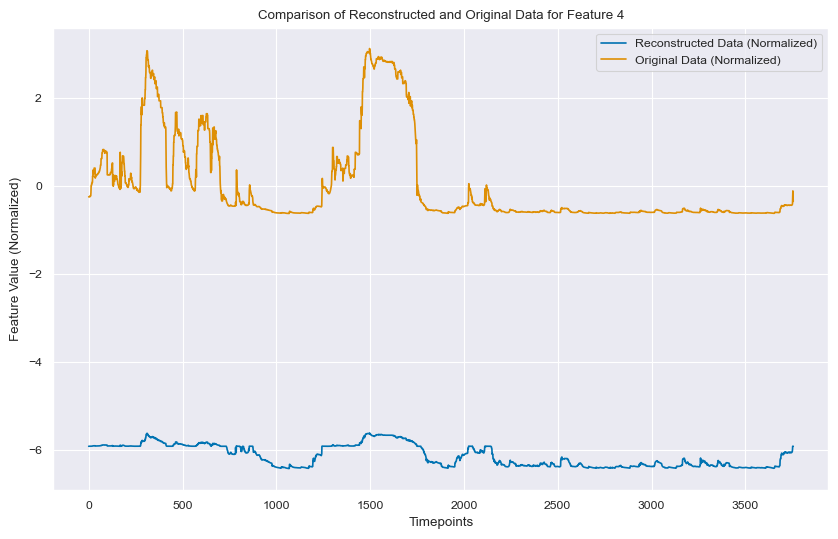

In [94]:
# Assuming train_data is your original_data
original_data = train_data

# Use the trained autoencoder to reconstruct the data
reconstructed_data = autoencoder.predict(train_data)

# Normalize the original and reconstructed data using the scaler from the DataGenerator
# We're using train_gen.scaler.transform to ensure the data is on the same scale
original_data_normalized = train_gen.scaler.transform(original_data.reshape(original_data.shape[0], -1)).reshape(original_data.shape)
reconstructed_data_normalized = train_gen.scaler.transform(reconstructed_data.reshape(reconstructed_data.shape[0], -1)).reshape(reconstructed_data.shape)

# Select a random feature for comparison
feature_index = 4  # or use np.random.randint to select a random index

# Extract this feature across all samples from the original and reconstructed data and ensure its shape is compatible for comparison
original_feature_values_normalized = original_data_normalized[:, feature_index, 0]
reconstructed_feature_values_normalized = reconstructed_data_normalized[:, feature_index, 0]

# Plot the reconstructed values for this feature
plt.figure(figsize=(10, 6))
plt.plot(reconstructed_feature_values_normalized, label='Reconstructed Data (Normalized)')

# Plot the original values for this feature
plt.plot(original_feature_values_normalized, label='Original Data (Normalized)')

plt.xlabel('Timepoints')
plt.ylabel('Feature Value (Normalized)')
plt.title(f'Comparison of Reconstructed and Original Data for Feature {feature_index}')
plt.legend()
plt.show()


## Training on multiple lifelines

In [3]:
import os
import pandas as pd
import numpy as np

# Directory containing the lifeline files
folder_path = 'dFBA_Data_Frames_Lifelines - Small'
file_names = sorted(os.listdir(folder_path))

# Ensure 3754 timepoints for all lifeline files
for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    
    # Load the lifeline DataFrame
    lifeline_df = pd.read_csv(file_path, sep="\t", index_col=0)
    
    if lifeline_df.shape[0] > 3754:
        print(f"Trimming {file_name} from {lifeline_df.shape[0]} timepoints to 3754 timepoints.")
        
        # Keep only the first 3754 rows
        trimmed_df = lifeline_df.iloc[:3754]
        
        # Write the modified DataFrame back to the file
        trimmed_df.to_csv(file_path, sep="\t")

# Now load and filter the lifeline data for the main processing
data_list = []
filtered_reactions = None  # To store the reactions kept after filtering

for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    lifeline_df = pd.read_csv(file_path, sep="\t", index_col=0)
    
    # For the first file, identify the reactions to keep
    if filtered_reactions is None:
        # Remove reactions with constant values over time
        non_constant_fluxes_df = lifeline_df.loc[:, (lifeline_df != lifeline_df.iloc[0]).any()]
        
        # Remove redundant reactions, keep one representative for coupled reactions
        unique_reactions_fluxes_df = non_constant_fluxes_df.loc[:, ~non_constant_fluxes_df.columns.duplicated()]
        
        # The reactions to keep for all subsequent files
        filtered_reactions = unique_reactions_fluxes_df.columns
    
    # Filter reactions for the current file based on the identified reactions
    filtered_lifeline_df = lifeline_df[filtered_reactions]
    
    # Check for any shape mismatches
    if filtered_lifeline_df.shape != (3754, len(filtered_reactions)):
        print(f"Shape mismatch for file: {file_name}. Expected (3754, {len(filtered_reactions)}) but got {filtered_lifeline_df.shape}")

    # Add the filtered data to the data list
    data_list.append(filtered_lifeline_df.to_numpy())

data_3d = np.stack(data_list, axis=1)
print("Shape of the Big Matrix:", data_3d.shape)


Shape of the Big Matrix: (3754, 14, 48)


Test without Hyperparameter Tuning

In [20]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, RepeatVector, Dense, BatchNormalization
from tensorflow.keras.models import Model
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.utils import Sequence
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# DataGenerator class
class DataGenerator(Sequence):
    def __init__(self, data, batch_size=32, shuffle=False):
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.data))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_data = self.data[batch_indices]
        return batch_data, batch_data

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)


scaler = StandardScaler()

# Assuming you have data_3d defined elsewhere in your code
# Normalize each feature separately
for i in range(data_3d.shape[1]):
    data_3d[:, i, :] = scaler.fit_transform(data_3d[:, i, :])

merged_data = data_3d.reshape(data_3d.shape[0], -1)
original_data = merged_data.reshape(merged_data.shape[0], merged_data.shape[1], 1)

# Define the input layer
inp = Input(shape=(original_data.shape[1], original_data.shape[2]))

# Encoder layers
encoder = LSTM(120, activation='tanh', return_sequences=False, kernel_initializer='glorot_uniform')(inp)
latent = Dense(40, activation='tanh')(encoder)

# Decoder layers
repeated_latent = RepeatVector(original_data.shape[1])(latent)
decoder = LSTM(120, activation='tanh', return_sequences=True)(repeated_latent)
output = LSTM(original_data.shape[2], activation='linear', return_sequences=True)(decoder)

# Create the autoencoder model
autoencoder = Model(inputs=inp, outputs=output)
autoencoder.compile(optimizer='adam', loss='mse')

# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

for train_index, val_index in tscv.split(original_data):
    # Split data
    train, val = original_data[train_index], original_data[val_index]

    # Create data generators for this fold
    train_gen = DataGenerator(train, batch_size=32, shuffle=True)
    val_gen = DataGenerator(val, batch_size=32)

    # Fit the autoencoder for this fold using the generators
    history = autoencoder.fit(train_gen, validation_data=val_gen, epochs=30, callbacks=[reduce_lr, early_stop])

# Calculate RMSE
reconstruction_loss = np.sqrt(np.mean(np.square(original_data - autoencoder.predict(original_data))))
print(f"RMSE: {reconstruction_loss}")


Epoch 1/30
20/20 [==============================] - 31s 1s/step - loss: 1.0601 - val_loss: 1.1542 - lr: 0.0010
Epoch 2/30
20/20 [==============================] - 26s 1s/step - loss: 1.0590 - val_loss: 1.1549 - lr: 0.0010
Epoch 3/30
20/20 [==============================] - 26s 1s/step - loss: 1.0623 - val_loss: 1.1547 - lr: 0.0010
Epoch 4/30
20/20 [==============================] - 26s 1s/step - loss: 1.0579 - val_loss: 1.1552 - lr: 0.0010
Epoch 5/30
20/20 [==============================] - 26s 1s/step - loss: 1.0561 - val_loss: 1.1578 - lr: 0.0010
Epoch 6/30
20/20 [==============================] - 26s 1s/step - loss: 1.0472 - val_loss: 1.1683 - lr: 0.0010
Epoch 7/30
20/20 [==============================] - 26s 1s/step - loss: 1.0451 - val_loss: 1.1662 - lr: 5.0000e-04
Epoch 8/30
20/20 [==============================] - 25s 1s/step - loss: 1.0450 - val_loss: 1.1691 - lr: 5.0000e-04
Epoch 9/30
20/20 [==============================] - 26s 1s/step - loss: 1.0436 - val_loss: 1.1712 - lr: 

In [21]:
# Split the original_data into train and test sets
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(original_data, test_size=0.2, random_state=42)

# Create an encoder model
encoder_model = Model(inputs=inp, outputs=latent)

# Predict the latent and reconstructed data for the test set
latent_test_data = encoder_model.predict(test_data)
reconstructed_test_data = autoencoder.predict(test_data)

24/24 [==============================] - 9s 364ms/step


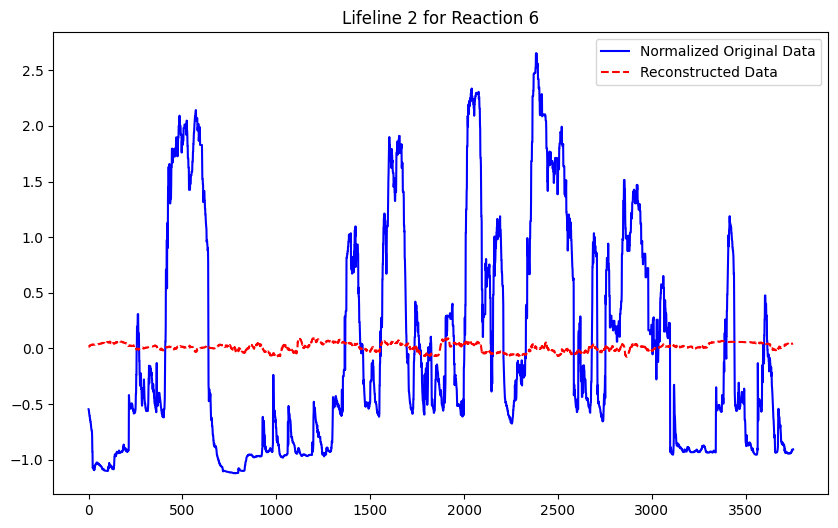

In [24]:
import matplotlib.pyplot as plt

# Reshape original_data back to its original 3D shape
original_data_3d = original_data.reshape(original_data.shape[0], 14, 48)

# Extract series for a specific lifeline and reaction
lifeline_index = 2
reaction_index = 6

# Normalized original series
normalized_original_series = original_data_3d[:, lifeline_index, reaction_index]

# Reconstructed series
reconstructed_series = reconstructed_data_3d[:, lifeline_index, reaction_index]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(normalized_original_series, label='Normalized Original Data', color='blue')
plt.plot(reconstructed_series, label='Reconstructed Data', color='red', linestyle='--')
plt.title(f"Lifeline {lifeline_index} for Reaction {reaction_index}")
plt.legend()
plt.show()


# Multiple Lifelines Testing with Hyperparameter Tuning

In [4]:
import numpy as np
import optuna
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, RepeatVector, Dense
from tensorflow.keras.models import Model
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.utils import Sequence
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

class DataGenerator(Sequence):
    def __init__(self, data, batch_size=32, shuffle=False):
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.data))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_data = self.data[batch_indices]
        return batch_data, batch_data

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

def objective(trial, data):
    # Hyperparameters
    hidden_units = trial.suggest_int('hidden_units', 10, 120)
    latent_units = trial.suggest_int('latent_units', 5, 40)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

    # Model Definition
    inp = Input(shape=(data.shape[1], data.shape[2]))
    encoder = LSTM(hidden_units, activation=activation, return_sequences=False)(inp)
    latent = Dense(latent_units, activation=activation)(encoder)
    repeated_latent = RepeatVector(data.shape[1])(latent)
    decoder = LSTM(hidden_units, activation=activation, return_sequences=True)(repeated_latent)
    output = LSTM(data.shape[2], activation='linear', return_sequences=True)(decoder)
    autoencoder = Model(inputs=inp, outputs=output)
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')

    # TimeSeriesSplit and Callbacks
    tscv = TimeSeriesSplit(n_splits=5)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    rmse = []

    for train_index, val_index in tscv.split(data):
        train, val = data[train_index], data[val_index]
        train_gen = DataGenerator(train, batch_size=32, shuffle=True)
        val_gen = DataGenerator(val, batch_size=32)
        history = autoencoder.fit(train_gen, validation_data=val_gen, epochs=30, callbacks=[reduce_lr, early_stop])
        reconstruction_loss = np.sqrt(np.mean(np.square(val - autoencoder.predict(val_gen))))
        rmse.append(reconstruction_loss)

    return np.mean(rmse)

scaler = StandardScaler()

# Normalize each feature separately
for i in range(data_3d.shape[1]):
    data_3d[:, i, :] = scaler.fit_transform(data_3d[:, i, :])

merged_data = data_3d.reshape(data_3d.shape[0], -1)
original_data = merged_data.reshape(merged_data.shape[0], merged_data.shape[1], 1)


c:\Users\elysi\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Now use the objective function
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, original_data), n_trials=5)


[I 2023-11-17 22:23:30,356] A new study created in memory with name: no-name-b3a99294-8f63-44bc-a922-78d9c52448b0


Epoch 1/30
20/20 [==============================] - 19s 744ms/step - loss: 1.0600 - val_loss: 1.1539 - lr: 0.0028
Epoch 2/30
20/20 [==============================] - 15s 739ms/step - loss: 1.0597 - val_loss: 1.1538 - lr: 0.0028
Epoch 3/30
20/20 [==============================] - 19s 957ms/step - loss: 1.0590 - val_loss: 1.1544 - lr: 0.0028
Epoch 4/30
20/20 [==============================] - 14s 690ms/step - loss: 1.0574 - val_loss: 1.1549 - lr: 0.0028
Epoch 5/30
20/20 [==============================] - 14s 712ms/step - loss: 1.0564 - val_loss: 1.1577 - lr: 0.0028
Epoch 6/30
20/20 [==============================] - 14s 738ms/step - loss: 1.0728 - val_loss: 1.1548 - lr: 0.0028
Epoch 7/30
20/20 [==============================] - 13s 680ms/step - loss: 1.0589 - val_loss: 1.1545 - lr: 0.0028
Epoch 8/30
20/20 [==============================] - 13s 673ms/step - loss: 1.0586 - val_loss: 1.1545 - lr: 0.0014
Epoch 9/30
20/20 [==============================] - 13s 638ms/step - loss: 1.0584 - val_

[I 2023-11-17 22:56:17,783] Trial 0 finished with value: 0.9821244168898637 and parameters: {'hidden_units': 17, 'latent_units': 34, 'activation': 'tanh', 'learning_rate': 0.0027572975779302763}. Best is trial 0 with value: 0.9821244168898637.


Epoch 1/30
20/20 [==============================] - 18s 714ms/step - loss: 1.0640 - val_loss: 1.1546 - lr: 0.0049
Epoch 2/30
20/20 [==============================] - 14s 696ms/step - loss: 1.0596 - val_loss: 1.1543 - lr: 0.0049
Epoch 3/30
20/20 [==============================] - 14s 690ms/step - loss: 1.0593 - val_loss: 1.1545 - lr: 0.0049
Epoch 4/30
20/20 [==============================] - 13s 670ms/step - loss: 1.0583 - val_loss: 1.1547 - lr: 0.0049
Epoch 5/30
20/20 [==============================] - 14s 685ms/step - loss: 1.0591 - val_loss: 1.1558 - lr: 0.0049
Epoch 6/30
20/20 [==============================] - 14s 724ms/step - loss: 1.0577 - val_loss: 1.1584 - lr: 0.0049
Epoch 7/30
20/20 [==============================] - 14s 697ms/step - loss: 1.0563 - val_loss: 1.1574 - lr: 0.0049
Epoch 8/30
20/20 [==============================] - 14s 706ms/step - loss: 1.0564 - val_loss: 1.1955 - lr: 0.0024
Epoch 9/30
20/20 [==============================] - 14s 702ms/step - loss: 1.0577 - val_

[I 2023-11-17 23:53:03,473] Trial 1 finished with value: 0.9832552964298795 and parameters: {'hidden_units': 37, 'latent_units': 31, 'activation': 'tanh', 'learning_rate': 0.004857336291933017}. Best is trial 0 with value: 0.9821244168898637.


Epoch 1/30
20/20 [==============================] - 18s 749ms/step - loss: 1.0600 - val_loss: 1.1561 - lr: 0.0018
Epoch 2/30
20/20 [==============================] - 14s 715ms/step - loss: 1.0596 - val_loss: 1.1556 - lr: 0.0018
Epoch 3/30
20/20 [==============================] - 13s 679ms/step - loss: 1.0594 - val_loss: 1.1561 - lr: 0.0018
Epoch 4/30
20/20 [==============================] - 13s 672ms/step - loss: 1.0590 - val_loss: 1.1842 - lr: 0.0018
Epoch 5/30
20/20 [==============================] - 13s 671ms/step - loss: 1.0585 - val_loss: nan - lr: 0.0018
Epoch 6/30
20/20 [==============================] - 13s 673ms/step - loss: 1.0573 - val_loss: nan - lr: 0.0018
Epoch 7/30
20/20 [==============================] - 14s 687ms/step - loss: nan - val_loss: nan - lr: 0.0018
Epoch 8/30
20/20 [==============================] - 14s 719ms/step - loss: nan - val_loss: nan - lr: 8.8841e-04
Epoch 9/30
20/20 [==============================] - 15s 732ms/step - loss: nan - val_loss: nan - lr: 8

[W 2023-11-18 00:23:05,316] Trial 2 failed with parameters: {'hidden_units': 31, 'latent_units': 14, 'activation': 'relu', 'learning_rate': 0.0017768104525453558} because of the following error: The value nan is not acceptable.
[W 2023-11-18 00:23:05,317] Trial 2 failed with value nan.


Epoch 1/30
20/20 [==============================] - 26s 953ms/step - loss: 1.0600 - val_loss: 1.1543 - lr: 0.0025
Epoch 2/30
20/20 [==============================] - 20s 1s/step - loss: 1.0591 - val_loss: 1.1635 - lr: 0.0025
Epoch 3/30
20/20 [==============================] - 21s 1s/step - loss: 1.0560 - val_loss: 1.1589 - lr: 0.0025
Epoch 4/30
20/20 [==============================] - 21s 1s/step - loss: 1.0556 - val_loss: 1.1571 - lr: 0.0025
Epoch 5/30
20/20 [==============================] - 20s 1s/step - loss: 1.0571 - val_loss: 1.1567 - lr: 0.0025
Epoch 6/30
20/20 [==============================] - 21s 1s/step - loss: 1.0563 - val_loss: 1.1584 - lr: 0.0025
Epoch 7/30
20/20 [==============================] - 21s 1s/step - loss: 1.0552 - val_loss: 1.1619 - lr: 0.0013
Epoch 8/30
20/20 [==============================] - 21s 1s/step - loss: 1.0504 - val_loss: 1.1638 - lr: 0.0013
Epoch 9/30
20/20 [==============================] - 22s 1s/step - loss: 1.0462 - val_loss: 1.1558 - lr: 0.001

[I 2023-11-18 01:37:45,860] Trial 3 finished with value: 0.9834764353128753 and parameters: {'hidden_units': 66, 'latent_units': 17, 'activation': 'tanh', 'learning_rate': 0.0025142549749727202}. Best is trial 0 with value: 0.9821244168898637.


Epoch 1/30
20/20 [==============================] - 17s 679ms/step - loss: 1.0618 - val_loss: 1.1557 - lr: 1.6965e-05
Epoch 2/30
20/20 [==============================] - 13s 675ms/step - loss: 1.0614 - val_loss: 1.1555 - lr: 1.6965e-05
Epoch 3/30
20/20 [==============================] - 13s 658ms/step - loss: 1.0611 - val_loss: 1.1554 - lr: 1.6965e-05
Epoch 4/30
20/20 [==============================] - 13s 672ms/step - loss: 1.0608 - val_loss: 1.1552 - lr: 1.6965e-05
Epoch 5/30
20/20 [==============================] - 14s 728ms/step - loss: 1.0606 - val_loss: 1.1551 - lr: 1.6965e-05
Epoch 6/30
20/20 [==============================] - 13s 663ms/step - loss: 1.0604 - val_loss: 1.1550 - lr: 1.6965e-05
Epoch 7/30
20/20 [==============================] - 13s 675ms/step - loss: 1.0603 - val_loss: 1.1550 - lr: 1.6965e-05
Epoch 8/30
20/20 [==============================] - 14s 712ms/step - loss: 1.0602 - val_loss: 1.1549 - lr: 1.6965e-05
Epoch 9/30
20/20 [==============================] - 14s 

[I 2023-11-18 02:31:47,572] Trial 4 finished with value: 0.9822022525551743 and parameters: {'hidden_units': 18, 'latent_units': 23, 'activation': 'relu', 'learning_rate': 1.696475344265462e-05}. Best is trial 0 with value: 0.9821244168898637.


In [7]:
best_params = study.best_params
best_loss = study.best_value
print("Best Hyperparameters:", best_params)
print("Best Loss:", best_loss)

Best Hyperparameters: {'hidden_units': 17, 'latent_units': 34, 'activation': 'tanh', 'learning_rate': 0.0027572975779302763}
Best Loss: 0.9821244168898637


In [8]:
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, LSTM, RepeatVector, Dense, Reshape

# Get the best hyperparameters from Optuna
best_params = study.best_params
hidden_units = best_params['hidden_units']
latent_units = best_params['latent_units']
activation = best_params['activation']

# Reshape the data for the autoencoder
reshaped_data = original_data

# Define the input layer
inp = Input(shape=(reshaped_data.shape[1], reshaped_data.shape[2]))

# Reshape the input to match desired dimensions
reshaped_input = Reshape((reshaped_data.shape[1] * reshaped_data.shape[2],))(inp)

# Encoder layers
encoder = Dense(hidden_units, activation=activation)(reshaped_input)
latent = Dense(latent_units, activation=activation)(encoder)

# Decoder layers
decoder = Dense(hidden_units, activation=activation)(latent)
output = Dense(reshaped_data.shape[1] * reshaped_data.shape[2], activation='linear')(decoder)

# Reshape the output to match original dimensions
reshaped_output = Reshape((reshaped_data.shape[1], reshaped_data.shape[2]))(output)

# Create the autoencoder model with best hyperparameters
autoencoder = Model(inputs=inp, outputs=reshaped_output)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder with best hyperparameters
autoencoder.fit(reshaped_data, reshaped_data, epochs=20, batch_size=32)

# Get the reconstructed data
reconstructed_data = autoencoder.predict(reshaped_data)

# Reshape the reconstructed data and original data for visualization
reconstructed_data = np.squeeze(reconstructed_data)
original_data = np.squeeze(reshaped_data)


Epoch 1/20
118/118 [==============================] - 1s 4ms/step - loss: 0.7328
Epoch 2/20
118/118 [==============================] - 0s 2ms/step - loss: 0.4381
Epoch 3/20
118/118 [==============================] - 0s 2ms/step - loss: 0.3475
Epoch 4/20
118/118 [==============================] - 0s 2ms/step - loss: 0.2909
Epoch 5/20
118/118 [==============================] - 0s 2ms/step - loss: 0.2518
Epoch 6/20
118/118 [==============================] - 0s 2ms/step - loss: 0.2230
Epoch 7/20
118/118 [==============================] - 0s 2ms/step - loss: 0.2024
Epoch 8/20
118/118 [==============================] - 0s 2ms/step - loss: 0.1861
Epoch 9/20
118/118 [==============================] - 0s 2ms/step - loss: 0.1687
Epoch 10/20
118/118 [==============================] - 0s 2ms/step - loss: 0.1562
Epoch 11/20
118/118 [==============================] - 0s 2ms/step - loss: 0.1464
Epoch 12/20
118/118 [==============================] - 0s 2ms/step - loss: 0.1372
Epoch 13/20
118/118 [====

118/118 [==============================] - 0s 1ms/step


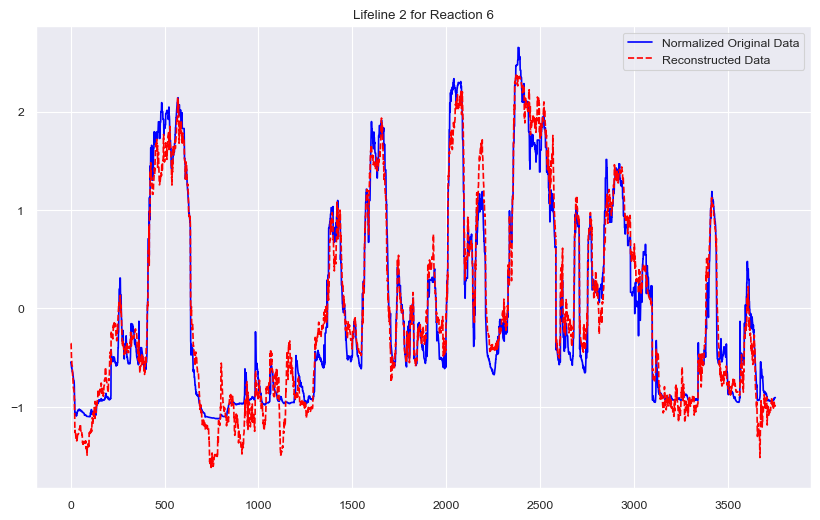

In [9]:
import matplotlib.pyplot as plt

original_data_reshaped = original_data.reshape(original_data.shape[0], original_data.shape[1], 1)
reconstructed_data_2d = autoencoder.predict(original_data_reshaped)

# Reshape reconstructed data back to the original 3D shape
reconstructed_data_3d = reconstructed_data_2d.reshape(data_3d.shape[0], data_3d.shape[1], data_3d.shape[2])

# Extract series for a specific lifeline and reaction
lifeline_index = 2
reaction_index = 6

# Normalized original series
normalized_original_series = data_3d[:, lifeline_index, reaction_index]

# Reconstructed series
reconstructed_series = reconstructed_data_3d[:, lifeline_index, reaction_index]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(normalized_original_series, label='Normalized Original Data', color='blue')
plt.plot(reconstructed_series, label='Reconstructed Data', color='red', linestyle='--')
plt.title(f"Lifeline {lifeline_index} for Reaction {reaction_index}")
plt.legend()
plt.show()


In [11]:
import pandas as pd

# Convert the latent data to a DataFrame
latent_df = pd.DataFrame(latent_data)

# Save to a CSV file
latent_df.to_csv("latent_data_14lifelines.csv", index=False)


In [ ]:
# Save the entire model to a file
autoencoder.save('path_to_14lifeline_autoencoder.h5')  # The .h5 extension indicates a HDF5 file

In [ ]:
# Step 1: Create the encoder model
encoder_model = Model(inputs=inp, outputs=latent)

# Step 2: Get the weights of the first layer of the encoder
# (assuming 'encoder' is the first layer of your encoder)
encoder_weights = encoder_model.layers[1].get_weights()[0]

# Step 3: Analyze the weights
# You can use various methods to analyze these weights.
# For example, you can look at the absolute values to see which original features
# contribute most to each latent feature.

# Printing the shape of the weights for understanding
print("Shape of encoder weights:", encoder_weights.shape)

# If you want to visualize the weights for each latent feature
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a list of names for your original features
feature_names = ['Feature1', 'Feature2', 'Feature3', ...]  # Replace with your actual feature names

for i in range(latent_units):  # Loop over each latent feature
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_names, y=encoder_weights[:, i])
    plt.title(f'Feature Contributions to Latent Feature {i}')
    plt.xticks(rotation=45)
    plt.show()


## Interpretation of Latent Space

Latent Space Visualization

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Apply t-SNE to the latent representations
tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(latent_representations)

# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.5)
plt.title('t-SNE visualization of Latent Space')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()
